In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import seaborn as sns
from ema_workbench import (Scenario, MultiprocessingEvaluator, ScalarOutcome, ema_logging)
from ema_workbench import  Policy,Scenario,Constraint,Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated,
                                                     rebuild_platypus_population)
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from platypus import Hypervolume

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

# parameters for improved visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

In [8]:
df = pd.read_csv("mordm/results_final/final_selected_policies.csv")
df.columns

Index(['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1', 'A.4_Total Costs', 'A.4_Dike Investment Costs',
       'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
       'A.5_Total Costs', 'A.5_Dike Investment Costs',
       'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
       'RfR Total Costs', 'Expected Evacuation Costs', 'Overijssel_Deaths',
       'Overijssel_Damages', 'Overijssel_Investment', 'Overijssel_RfR_num',
       'Scenario', 'cluster', 'TotalCost'],
      dtype='object')

In [9]:
levers_name = ['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1']

In [10]:
policies = df[levers_name]

In [11]:
policies.columns

Index(['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1'],
      dtype='object')

In [12]:
debate_outcome = [1,0,0,0,1,0,
                  1,0,0,0,3,
                  0,0,0,
                  0,5,0,
                  5,0,5,
                  0]
debate_outcome_df = pd.DataFrame([debate_outcome], columns=levers_name)

In [13]:
debate_outcome_df

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,5,0,5,0,5,0


In [14]:
complete_policies = pd.concat([policies, debate_outcome_df], ignore_index=True)

In [15]:
complete_policies

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1
0,0,0,0,0,0,0,0,0,0,0,...,1,3,2,0,5,5,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,4,5,0,5,4,3,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,3,4,5,5,5,5,0,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,5,1,5,5,5,0
4,0,0,0,0,0,1,0,0,0,0,...,5,2,1,5,1,5,4,0,5,3
5,0,0,0,0,0,0,0,0,0,0,...,0,0,5,5,3,0,0,2,5,3
6,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,1,5,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,5,0,1,0,4,5,3,0,1
8,0,1,0,0,0,0,0,0,0,0,...,4,3,1,1,4,5,5,4,0,0
9,0,0,0,0,0,0,0,0,0,0,...,4,2,1,4,2,0,0,0,5,0


In [16]:
policies_to_evaluate = []

for i, policy in complete_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [17]:
problem_formulation_id = 7
model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = model.uncertainties
outcomes = model.outcomes
levers = model.levers

In [12]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 2**8
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate,
                                            uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 9728 scenarios * 13 policies * 1 model(s) = 126464 experiments
100%|████████████████████████████████| 126464/126464 [1:39:03<00:00, 21.28it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
# save results
save_results(results, 'results/robustness_results.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/racheldelvin/Desktop/epa141a-flood-policy-optimization-overijssel/final assignment/results/robustness_results.tar.gz


In [18]:
results = load_results('results/robustness_results.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/racheldelvin/Desktop/epa141a-flood-policy-optimization-overijssel/final assignment/results/robustness_results.tar.gz


In [19]:
experiments, outcomes = results

## REGRET

In [113]:
overall_regret = {}
max_regret = {}
med_regret = {}

for outcome in model.outcomes:
    policy_column = experiments['policy']

    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.min(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    med_regret[outcome.name] = outcome_regret.median()

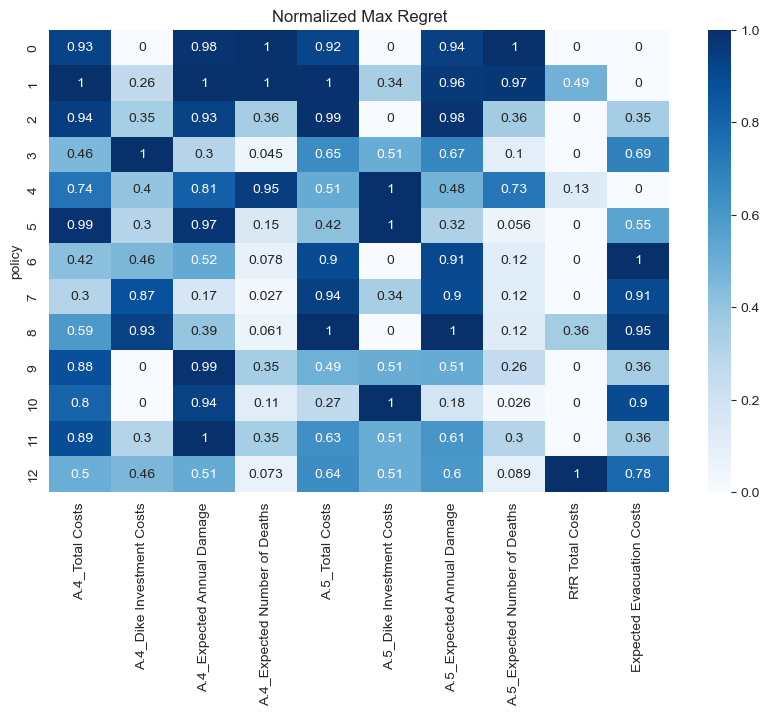

In [220]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='Blues', annot=True)
plt.title('Normalized Max Regret')
plt.show()

In [ ]:
max_regret_data = max_regret.drop(columns=['A.4_Total Costs','A.5_Total Costs'])

In [145]:
max_regret_data

,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,
0,0.000000e+00,7.351972e+07,0.036672,0.000000e+00,4.924533e+08,0.489630,0.0,0.000000
1,6.320800e+06,7.474933e+07,0.036728,2.503721e+07,5.043652e+08,0.476039,115300000.0,0.000000
2,8.453408e+06,6.954190e+07,0.013177,0.000000e+00,5.136361e+08,0.177358,0.0,22462.358695
3,2.416243e+07,2.254150e+07,0.001662,3.667668e+07,3.504631e+08,0.049120,0.0,43543.976276
4,9.695195e+06,6.063554e+07,0.034765,7.258061e+07,2.508455e+08,0.357998,30700000.0,0.000000
5,7.332080e+06,7.279698e+07,0.005426,7.258061e+07,1.688641e+08,0.027417,0.0,34845.761374
6,1.106877e+07,3.891547e+07,0.002848,0.000000e+00,4.762709e+08,0.057271,0.0,63301.505913
7,2.106862e+07,1.235217e+07,0.000993,2.503721e+07,4.690556e+08,0.056368,0.0,57295.779046
8,2.253757e+07,2.951667e+07,0.002258,0.000000e+00,5.237806e+08,0.058604,84600000.0,60357.008966


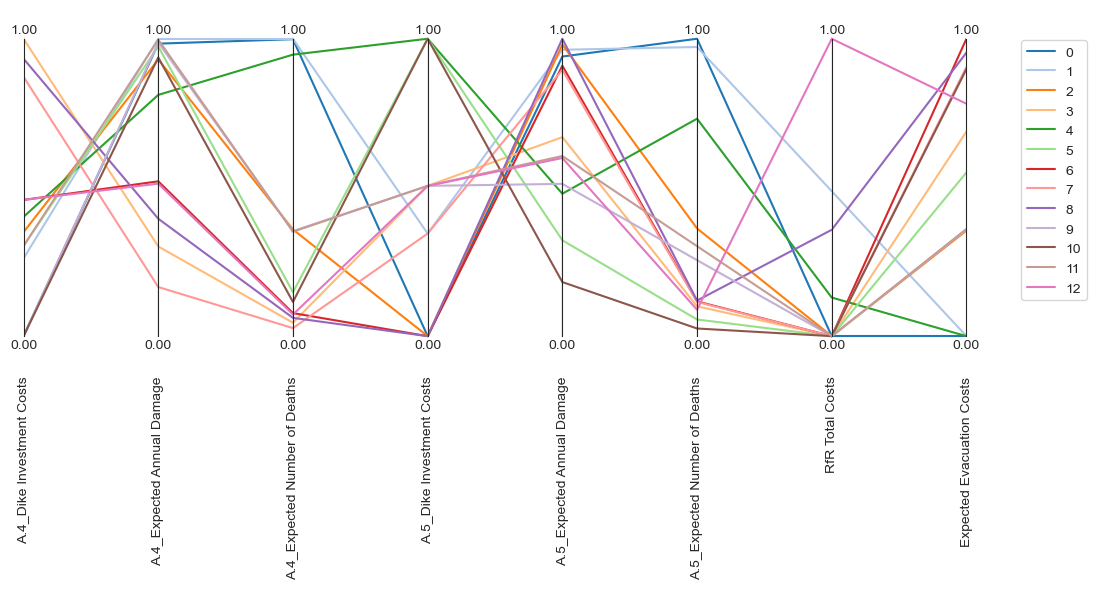

In [196]:
colors = sns.color_palette("tab20", n_colors=13)

normalized_max_regret = max_regret_data/max_regret_data.max()
data = normalized_max_regret

limits = parcoords.get_limits(data)
limits.loc[0, [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'RfR Total Costs', 'Expected Evacuation Costs'
]] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.show()

Pattern:
- Dike investment cost >< Expected annual damage
- Evacuation cost >< Expected death

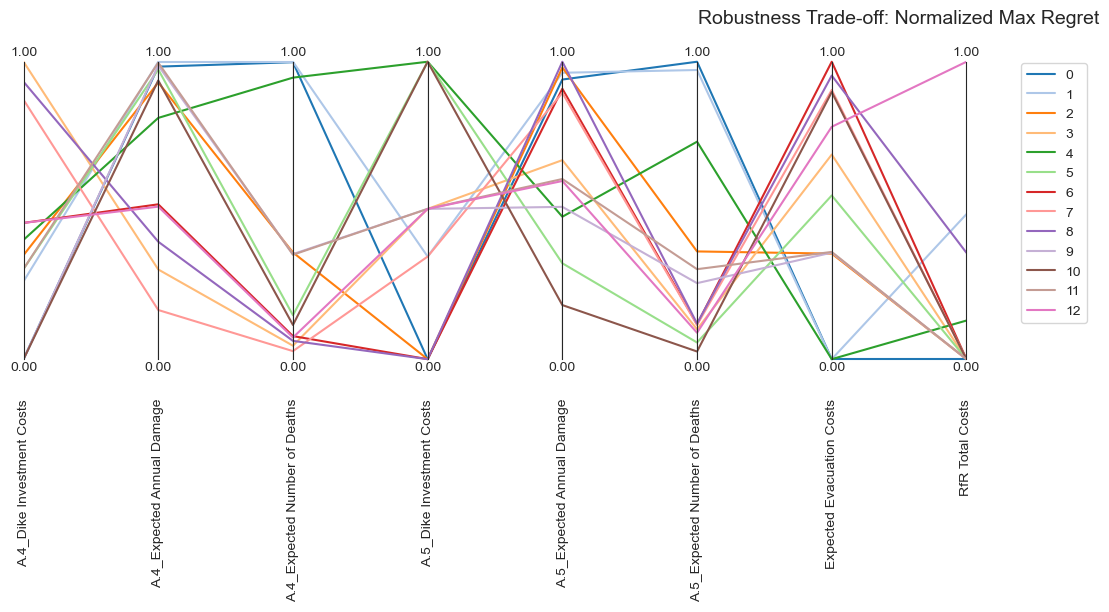

In [206]:
# Define your desired order of outcomes
ordered_cols = [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'Expected Evacuation Costs', 'RfR Total Costs'
]

# Reorder the DataFrame columns
data = normalized_max_regret[ordered_cols]

limits = parcoords.get_limits(data)
limits.loc[0, ordered_cols] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.title('Robustness Trade-off: Normalized Max Regret', fontsize=14)
plt.show()

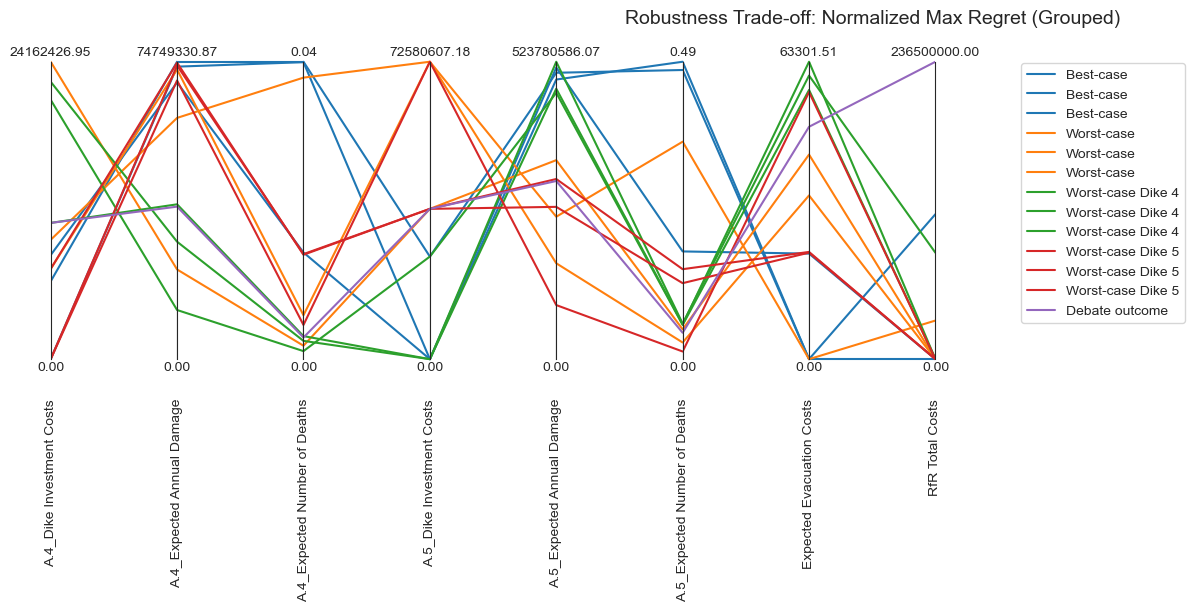

In [ ]:
# Define your desired order of outcomes
ordered_cols = [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'Expected Evacuation Costs', 'RfR Total Costs'
]

# Assign group labels and colors
policy_groups = [
    "Best-case", "Best-case", "Best-case",           # 0-2
    "Worst-case", "Worst-case", "Worst-case",        # 3-5
    "Worst-case Dike 4", "Worst-case Dike 4", "Worst-case Dike 4",  # 6-8
    "Worst-case Dike 5", "Worst-case Dike 5", "Worst-case Dike 5",  # 9-11
    "Debate outcome"                                 # 12
]
group_colors = {
    "Best-case": "#1f77b4",         # blue
    "Worst-case": "#ff7f0e",        # orange
    "Worst-case Dike 4": "#2ca02c", # green
    "Worst-case Dike 5": "#d62728", # red
    "Debate outcome": "#9467bd"     # purple
}

# Reorder the DataFrame columns
data = max_regret_data[ordered_cols]

limits = parcoords.get_limits(data)
limits.loc[0, ordered_cols] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)

# Plot each policy with group color
for i, (index, row) in enumerate(data.iterrows()):
    group = policy_groups[i]
    color = group_colors[group]
    paraxes.plot(row.to_frame().T, label=f"{group}", color=color)

paraxes.legend()
plt.title('Robustness Trade-off: Normalized Max Regretrouped)', fontsize=14)
plt.show()

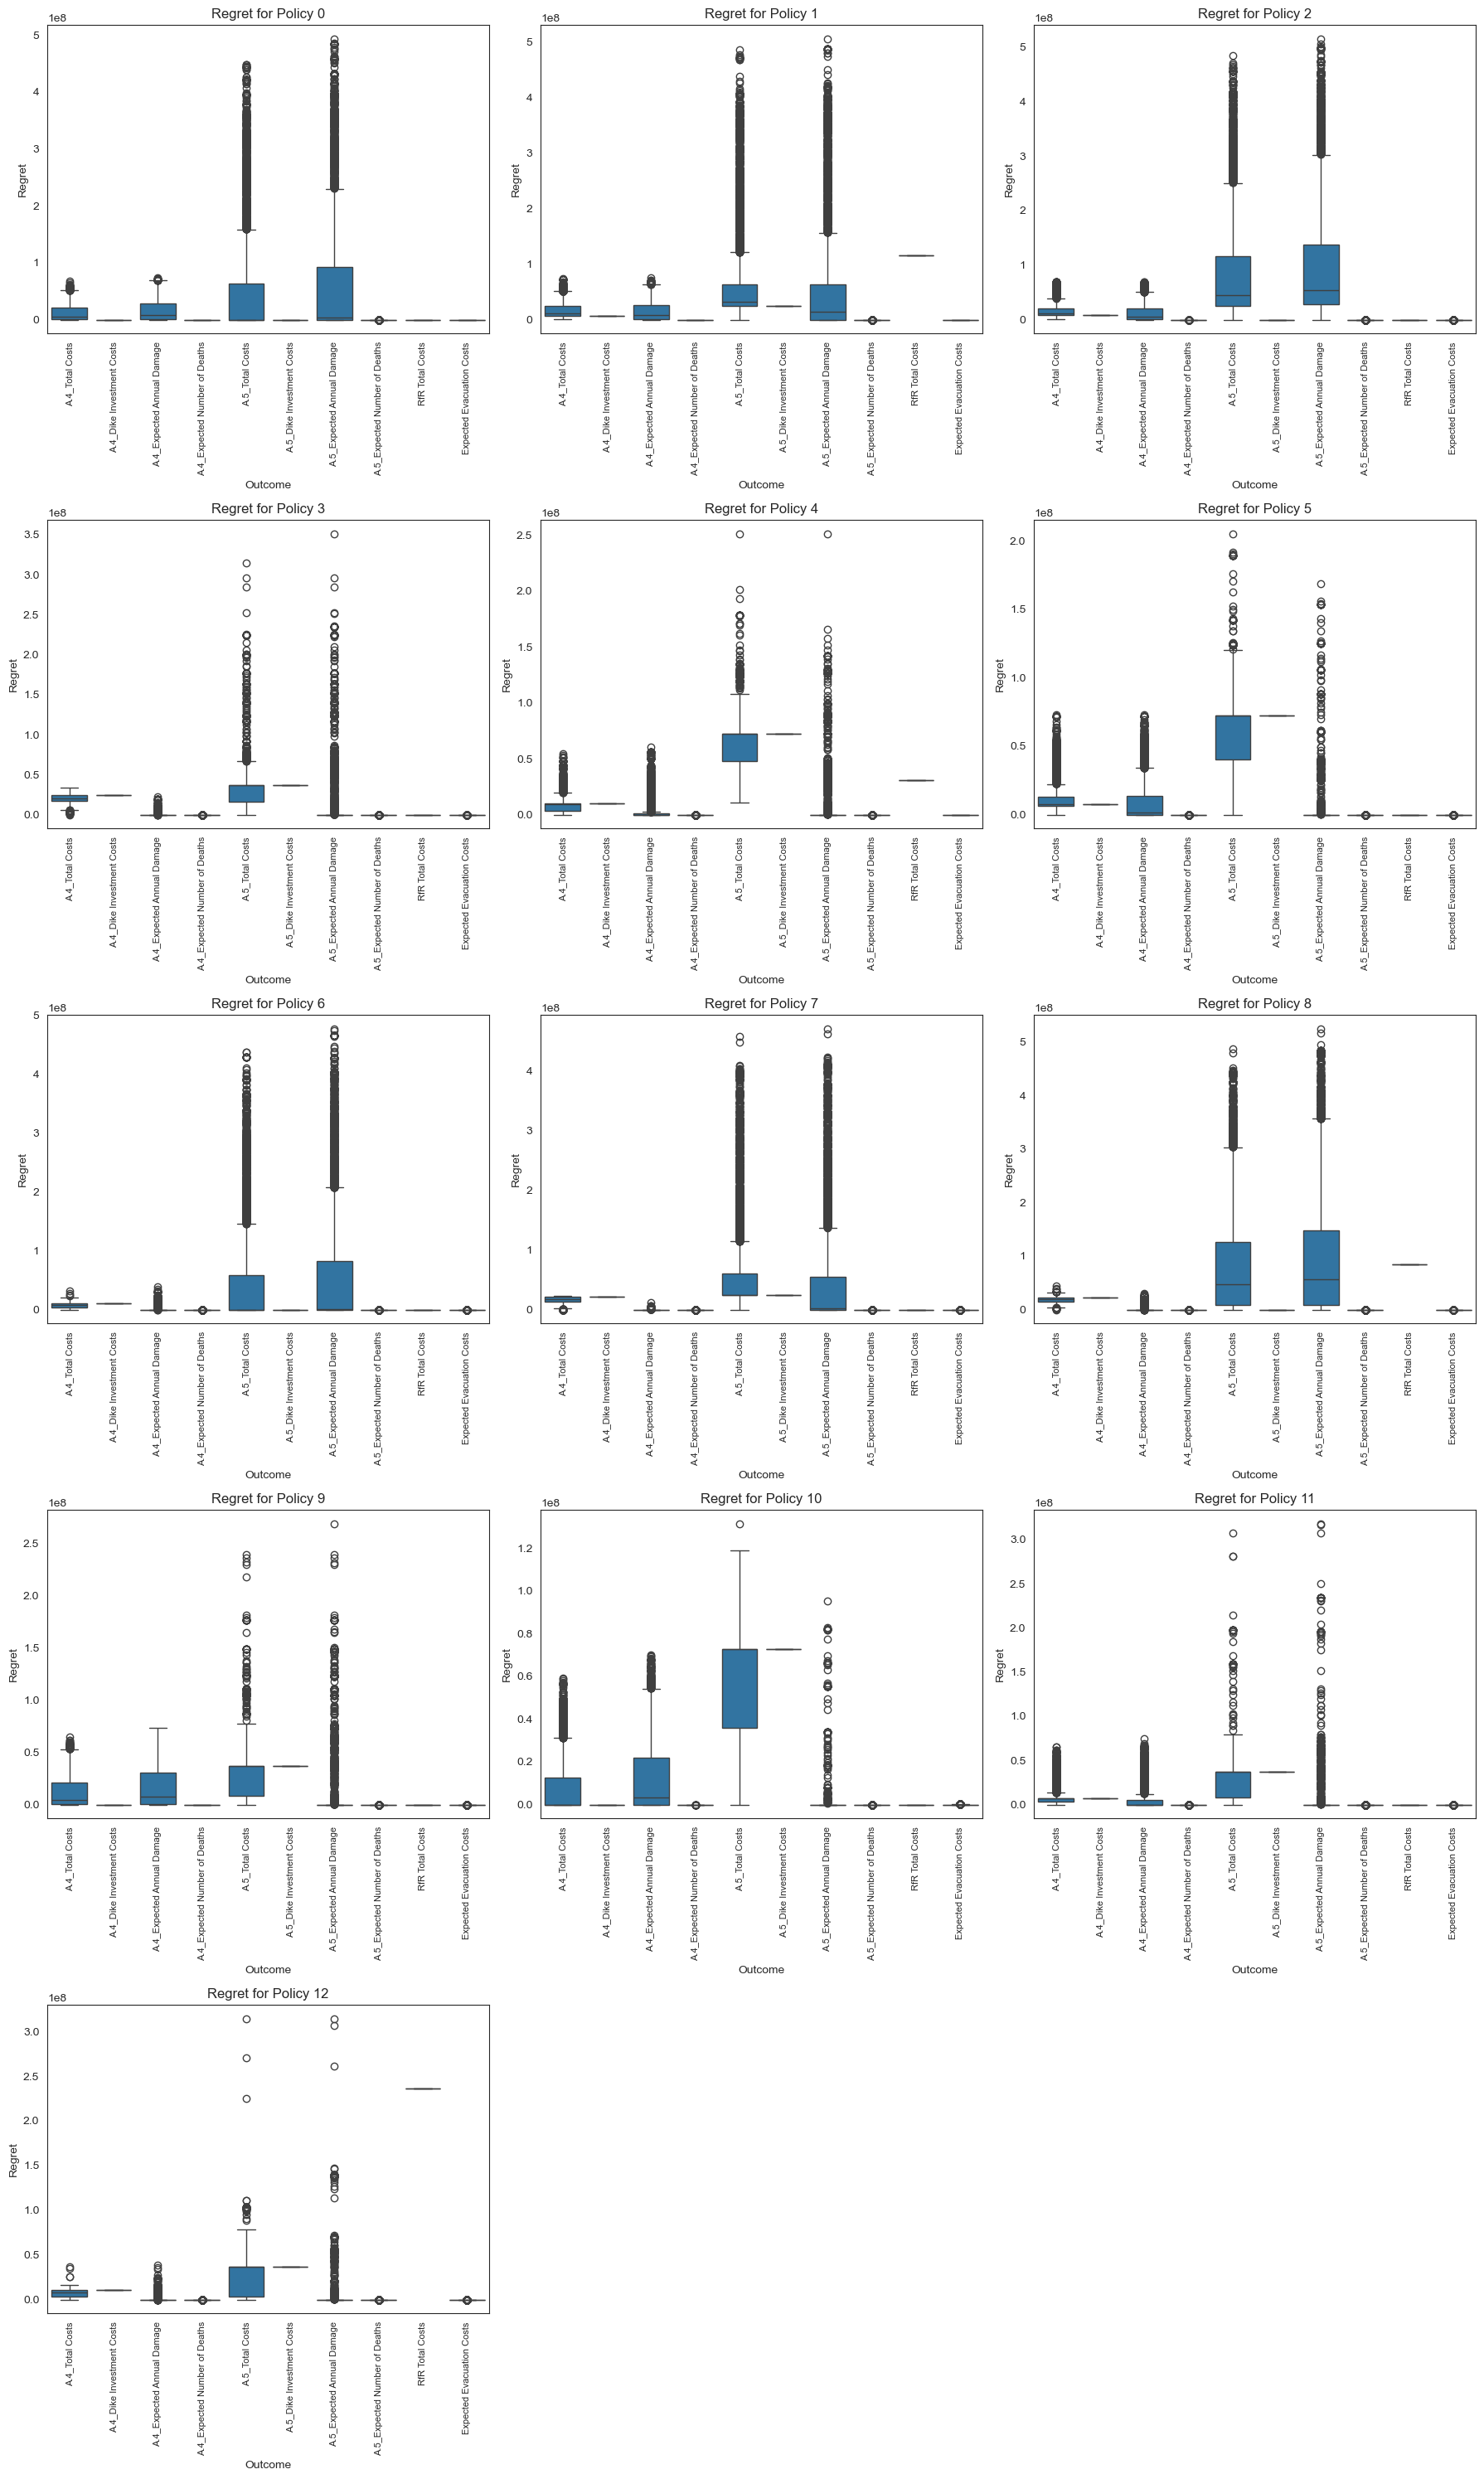

In [48]:
regret_records = []
for outcome_name, regret_df in overall_regret.items():
    for policy in regret_df.columns:
        for regret_value in regret_df[policy]:
            regret_records.append({
                'Outcome': outcome_name,
                'Policy': policy,
                'Regret': regret_value
            })
regret_long = pd.DataFrame(regret_records)

# Plot: one boxplot per policy, showing regret distributions for all outcomes
policies = regret_long['Policy'].unique()
n_policies = len(policies)
ncols = 3
nrows = int(np.ceil(n_policies / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False)
axes = axes.flatten()

for idx, policy in enumerate(policies):
    ax = axes[idx]
    data = regret_long[regret_long['Policy'] == policy]
    sns.boxplot(data=data, x='Outcome', y='Regret', ax=ax)
    ax.set_title(f'Regret for Policy {policy}')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

# Hide any unused subplots
for i in range(n_policies, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## SIGNAL-TO-NOISE

In [207]:
def calculate_stn_ratio(data):
    mean = np.mean(data)
    std = np.std(data)
    return (mean + 1) * (std + 1)

In [208]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = calculate_stn_ratio(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,3.286766e+14,1.000000e+00,3.286766e+14,1.021906,7.101234e+15,1.000000e+00,7.101234e+15,1.209332,1.0,1.000000e+00
1,4.188290e+14,6.320801e+06,3.013048e+14,1.021216,7.745978e+15,2.503722e+07,5.380320e+15,1.182335,115300001.0,1.000000e+00
2,3.269786e+14,8.453409e+06,1.979019e+14,1.006285,1.126183e+16,1.000000e+00,1.126183e+16,1.090536,1.0,2.506683e+07
3,6.487869e+13,2.416243e+07,1.402086e+12,1.000249,1.284468e+15,3.667668e+07,2.095988e+14,1.005275,1.0,3.817247e+07
4,1.087281e+14,9.695196e+06,2.564166e+13,1.007397,1.531413e+15,7.258061e+07,8.122876e+13,1.029184,30700001.0,1.000000e+00
5,2.542102e+14,7.332081e+06,1.431525e+14,1.002226,1.102307e+15,7.258061e+07,3.277090e+13,1.003050,1.0,4.287877e+07
6,5.588931e+13,1.106877e+07,3.995683e+12,1.000448,6.175117e+15,1.000000e+00,6.175117e+15,1.022595,1.0,1.557469e+08
7,5.041401e+13,2.106862e+07,7.176069e+11,1.000217,6.239231e+15,2.503722e+07,4.102706e+15,1.018680,1.0,1.701013e+08
8,7.582838e+13,2.253757e+07,2.243979e+12,1.000307,1.189330e+16,1.000000e+00,1.189330e+16,1.030677,84600001.0,1.838997e+08
9,3.382110e+14,1.000000e+00,3.382110e+14,1.007976,9.359297e+14,3.667668e+07,9.493982e+13,1.011556,1.0,2.363907e+07


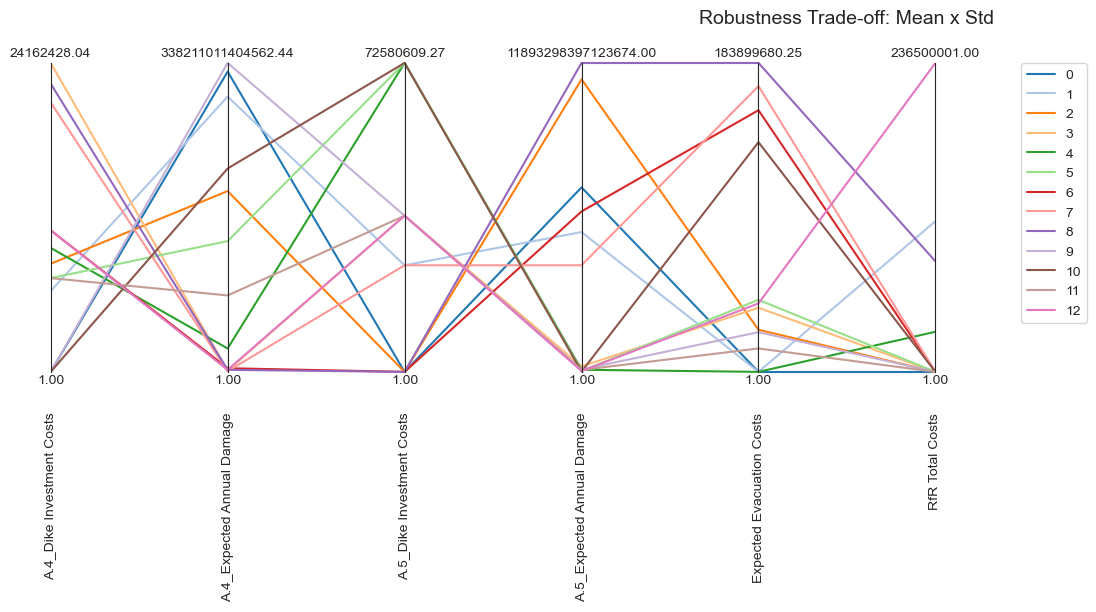

In [238]:
scores_data = scores.drop(columns=['A.4_Total Costs','A.5_Total Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths',
                                   ])
colors = sns.color_palette("tab20", n_colors=13)

ordered_cols = [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage',
    'Expected Evacuation Costs', 'RfR Total Costs'
]

# Reorder the DataFrame columns
data = scores_data[ordered_cols]

limits = parcoords.get_limits(data)
limits.loc[0, ordered_cols] = 1

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)

# Plot each policy with a label for the legend
for idx, (policy, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(policy), color=colors[idx])
paraxes.legend()
plt.title('Robustness Trade-off: Mean x Std', fontsize=14)
plt.show()

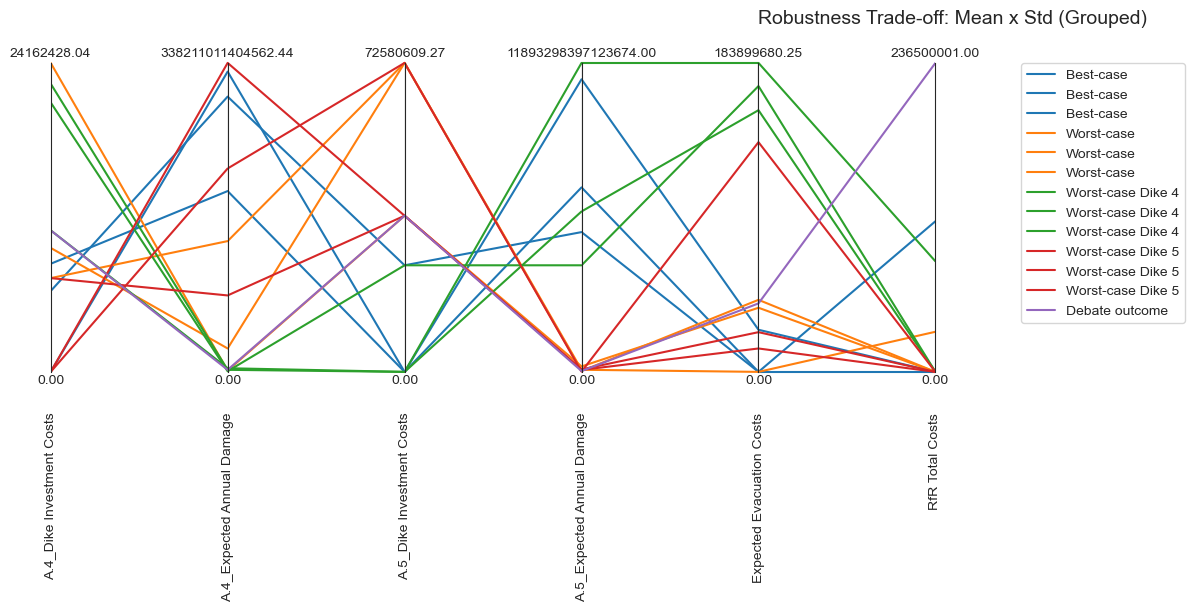

In [242]:
# Define your desired order of outcomes
ordered_cols = [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage',
    'Expected Evacuation Costs', 'RfR Total Costs'
]

# Assign group labels and colors
policy_groups = [
    "Best-case", "Best-case", "Best-case",           # 0-2
    "Worst-case", "Worst-case", "Worst-case",        # 3-5
    "Worst-case Dike 4", "Worst-case Dike 4", "Worst-case Dike 4",  # 6-8
    "Worst-case Dike 5", "Worst-case Dike 5", "Worst-case Dike 5",  # 9-11
    "Debate outcome"                                 # 12
]
group_colors = {
    "Best-case": "#1f77b4",         # blue
    "Worst-case": "#ff7f0e",        # orange
    "Worst-case Dike 4": "#2ca02c", # green
    "Worst-case Dike 5": "#d62728", # red
    "Debate outcome": "#9467bd"     # purple
}

# Reorder the DataFrame columns
data = scores_data[ordered_cols]

limits = parcoords.get_limits(data)
limits.loc[0, ordered_cols] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)

# Plot each policy with group color
for i, (index, row) in enumerate(data.iterrows()):
    group = policy_groups[i]
    color = group_colors[group]
    paraxes.plot(row.to_frame().T, label=f"{group}", color=color)

paraxes.legend()
plt.title('Robustness Trade-off: Mean x Std (Grouped)', fontsize=14, loc='left')
plt.show()

In [ ]:
scores_data.describe()

,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
count,1.300000e+01,1.300000e+01,13.000000,1.300000e+01,1.300000e+01,13.000000,1.300000e+01,1.300000e+01
mean,9.926134e+06,1.270605e+14,1.005770,3.188638e+07,3.573328e+15,1.047599,3.593077e+07,6.391573e+07
std,8.229773e+06,1.354709e+14,0.007547,2.771978e+07,4.441227e+15,0.069982,7.102976e+07,7.007895e+07
min,1.000000e+00,7.176069e+11,1.000217,1.000000e+00,1.081661e+13,1.001579,1.000000e+00,1.000000e+00
25%,6.320801e+06,2.243979e+12,1.000338,1.000000e+00,7.674594e+13,1.005275,1.000000e+00,1.392795e+07
50%,8.453409e+06,8.367793e+13,1.002226,3.667668e+07,2.095988e+14,1.018680,1.000000e+00,3.817247e+07
75%,1.106877e+07,2.226198e+14,1.007397,3.667668e+07,6.175117e+15,1.030677,3.070000e+07,1.367202e+08
max,2.416243e+07,3.382110e+14,1.021906,7.258061e+07,1.189330e+16,1.209332,2.365000e+08,1.838997e+08


## SATISFICING

In [ ]:
policy_medians = {}

for policy in np.unique(experiments['policy']):
    mask = experiments['policy'] == policy
    medians = {}
    for outcome in model.outcomes:
        values = outcomes[outcome.name][mask]
        medians[outcome.name] = np.me(values)
    policy_medians[policy] = medians

policy_medians_df = pd.DataFrame(policy_medians).T

policy_means = {}

for policy in np.unique(experiments['policy']):
    mask = experiments['policy'] == policy
    means = {}
    for outcome in model.outcomes:
        values = outcomes[outcome.name][mask]
        means[outcome.name] = np.mean(values)
    policy_means[policy] = means

policy_means_df = pd.DataFrame(policy_means).T

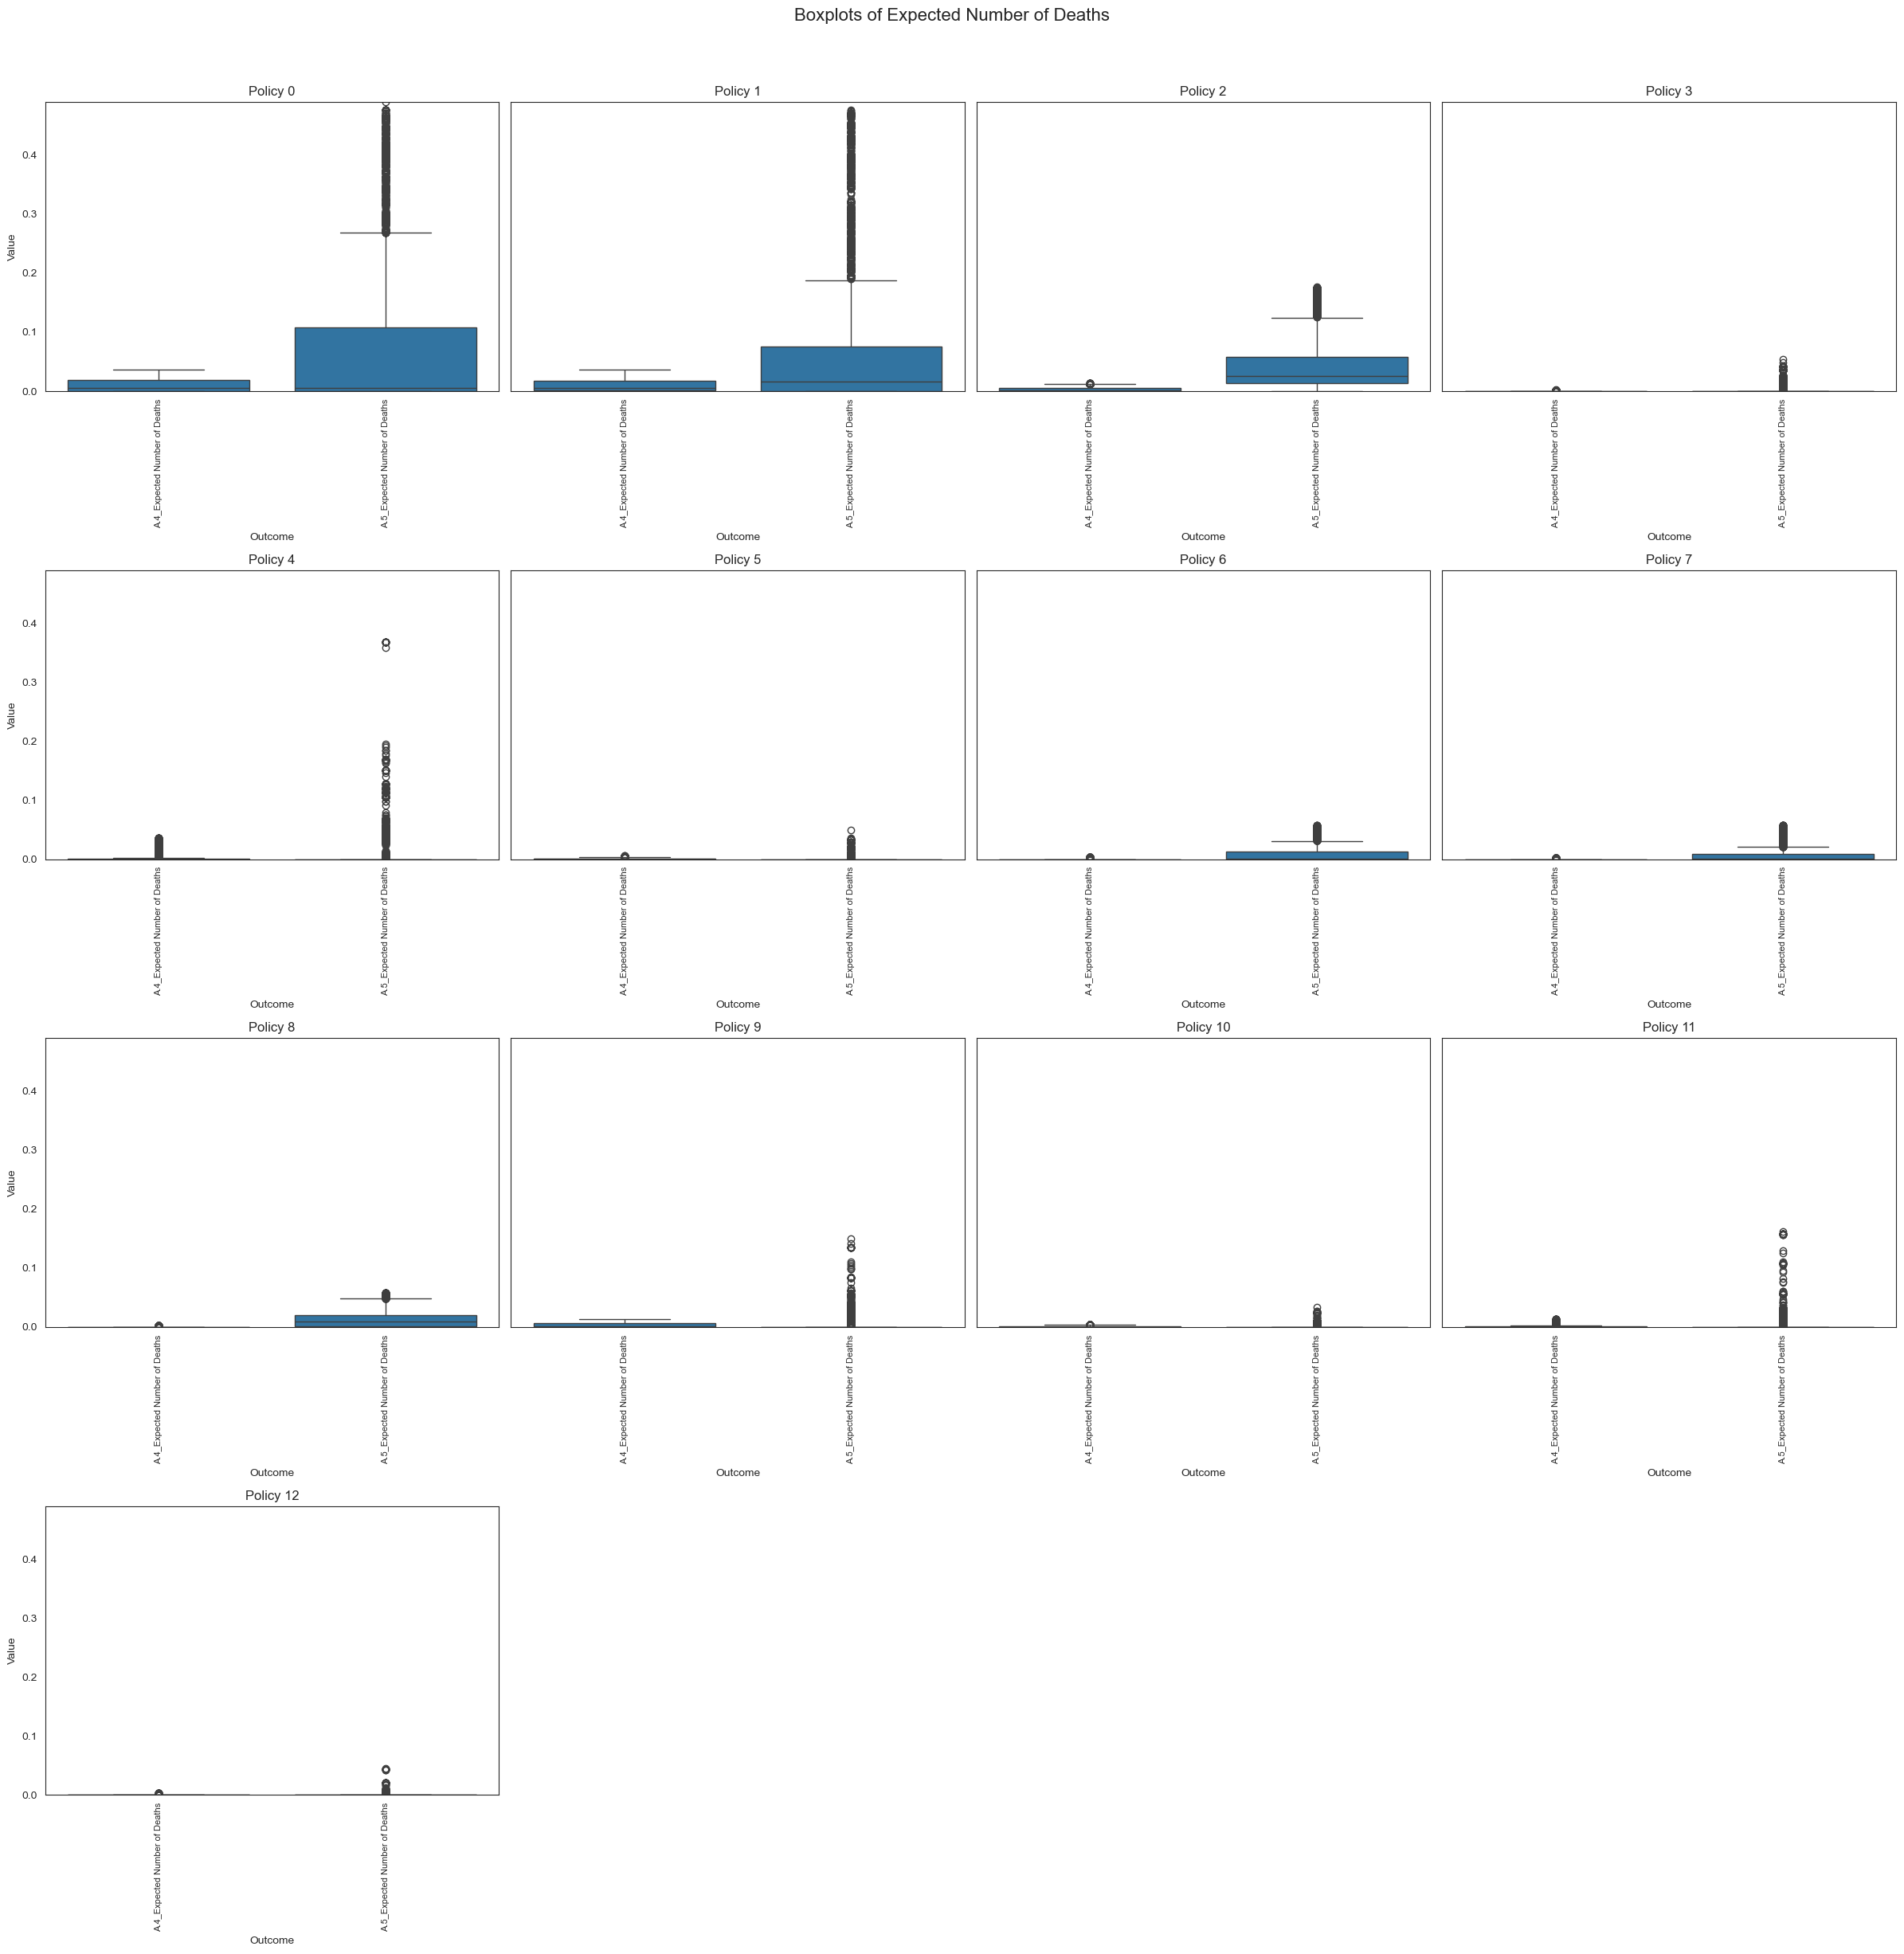

In [252]:
outcome_cols = [
    'A.4_Expected Number of Deaths', 
    'A.5_Expected Number of Deaths'
]

policies = np.unique(experiments['policy'])
n_policies = len(policies)
ncols = 4
nrows = int(np.ceil(n_policies / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False, sharey=True)
axes = axes.flatten()

# Find global y-limits
ymin, ymax = float('inf'), float('-inf')
for policy in policies:
    mask = experiments['policy'] == policy
    for outcome in outcome_cols:
        values = outcomes[outcome][mask]
        ymin = min(ymin, np.min(values))
        ymax = max(ymax, np.max(values))

for idx, policy in enumerate(policies):
    mask = experiments['policy'] == policy
    records = []
    for outcome in outcome_cols:
        for value in outcomes[outcome][mask]:
            records.append({'Outcome': outcome, 'Value': value})
    df_policy = pd.DataFrame(records)
    ax = axes[idx]
    sns.boxplot(data=df_policy, x='Outcome', y='Value', ax=ax)
    ax.set_title(f'Policy {policy}')
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_ylim(ymin, ymax)

# Hide any unused subplots
for i in range(n_policies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Boxplots of Expected Number of Deaths', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

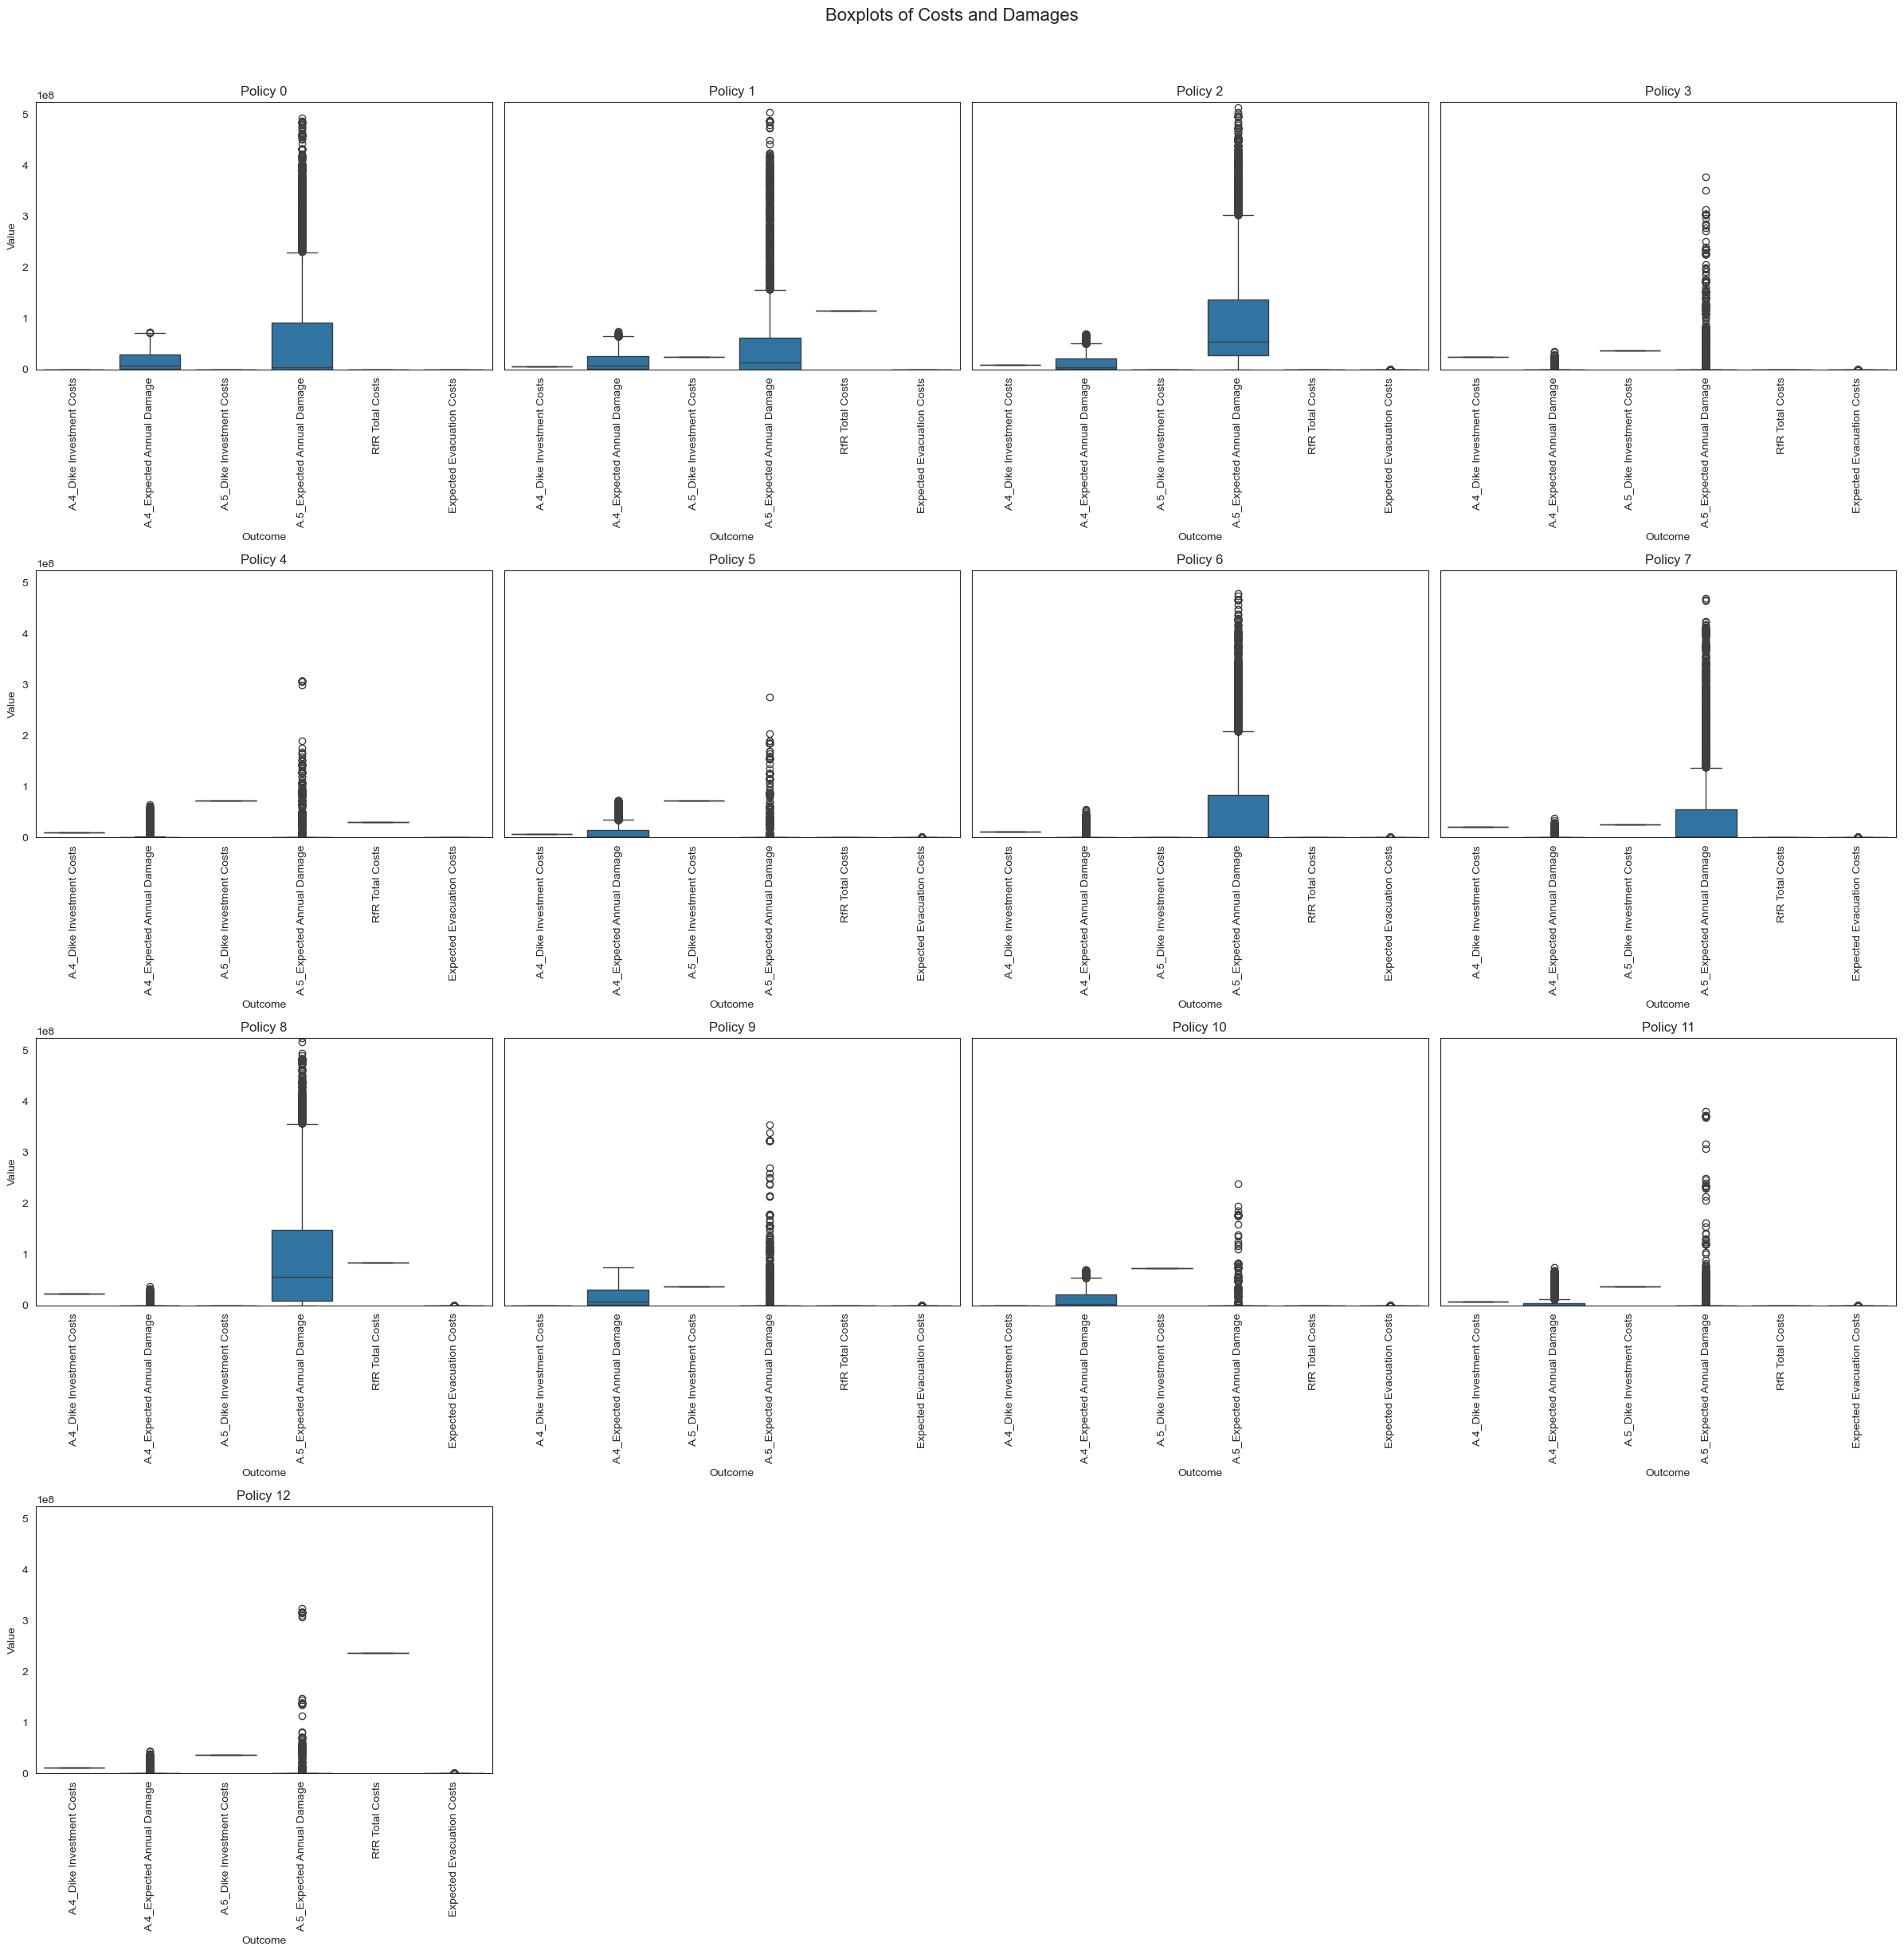

In [253]:
outcome_cols = [
    'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 
    'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage',
    'RfR Total Costs', 'Expected Evacuation Costs'
]

policies = np.unique(experiments['policy'])
n_policies = len(policies)
ncols = 4
nrows = int(np.ceil(n_policies / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False, sharey=True)
axes = axes.flatten()

# Find global y-limits
ymin, ymax = float('inf'), float('-inf')
for policy in policies:
    mask = experiments['policy'] == policy
    for outcome in outcome_cols:
        values = outcomes[outcome][mask]
        ymin = min(ymin, np.min(values))
        ymax = max(ymax, np.max(values))

for idx, policy in enumerate(policies):
    mask = experiments['policy'] == policy
    records = []
    for outcome in outcome_cols:
        for value in outcomes[outcome][mask]:
            records.append({'Outcome': outcome, 'Value': value})
    df_policy = pd.DataFrame(records)
    ax = axes[idx]
    sns.boxplot(data=df_policy, x='Outcome', y='Value', ax=ax)
    ax.set_title(f'Policy {policy}')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.set_ylim(ymin, ymax)

# Hide any unused subplots
for i in range(n_policies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Boxplots of Costs and Damages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [190]:
satisficing_percent = {}

thresholds = {
    'A.4_Total Costs': 11100000,
    'A.4_Expected Number of Deaths': 1,
    'A.4_Expected Annual Damage': 0,
    'A.4_Dike Investment Costs': 11100000,
    'A.5_Total Costs': 36700000,
    'A.5_Expected Number of Deaths': 1, # 0.04 IS THE SMALLEST
    'A.5_Expected Annual Damage': 0,
    'A.5_Dike Investment Costs': 36700000,
    'RfR Total Costs': 150000000,
    'Expected Evacuation Costs': 50000000
}

for outcome in model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name], 
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })
    # Pivot so columns are policies, rows are scenarios
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    
    # Calculate % of scenarios meeting the threshold for each policy
    threshold = thresholds[outcome.name]
    is_satisficing = data <= threshold
    percent_satisficing = is_satisficing.sum(axis=0) / is_satisficing.shape[0]  # percent
    
    satisficing_percent[outcome.name] = percent_satisficing

# Convert to DataFrame: rows=policies, cols=outcomes, values=% satisficing
satisficing_percent_df = pd.DataFrame(satisficing_percent)
satisficing_percent_df

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,,,
0,0.570210,1.0,0.192434,1.0,0.617496,1.0,0.432155,1.0,1.0,1.0
1,0.383429,1.0,0.104441,1.0,0.496608,1.0,0.356908,1.0,1.0,1.0
2,0.265728,1.0,0.121711,1.0,0.358964,1.0,0.084807,1.0,1.0,1.0
3,0.000000,0.0,0.892887,1.0,0.870991,1.0,0.870991,1.0,1.0,1.0
4,0.779091,1.0,0.587377,1.0,0.000000,0.0,0.894223,1.0,1.0,1.0
5,0.592002,1.0,0.384766,1.0,0.000000,0.0,0.941817,1.0,1.0,1.0
6,0.921464,1.0,0.921464,1.0,0.620169,1.0,0.484375,1.0,1.0,1.0
7,0.000000,0.0,0.960732,1.0,0.569901,1.0,0.488590,1.0,1.0,1.0
8,0.000000,0.0,0.892784,1.0,0.393812,1.0,0.179071,1.0,1.0,1.0


In [191]:
satisficing_df = satisficing_percent_df.drop(columns=['A.4_Total Costs', 'A.5_Total Costs', 'RfR Total Costs', 'Expected Evacuation Costs'])
satisficing_df

,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths
policy,,,,,,
0,1.0,0.192434,1.0,1.0,0.432155,1.0
1,1.0,0.104441,1.0,1.0,0.356908,1.0
2,1.0,0.121711,1.0,1.0,0.084807,1.0
3,0.0,0.892887,1.0,1.0,0.870991,1.0
4,1.0,0.587377,1.0,0.0,0.894223,1.0
5,1.0,0.384766,1.0,0.0,0.941817,1.0
6,1.0,0.921464,1.0,1.0,0.484375,1.0
7,0.0,0.960732,1.0,1.0,0.488590,1.0
8,0.0,0.892784,1.0,1.0,0.179071,1.0


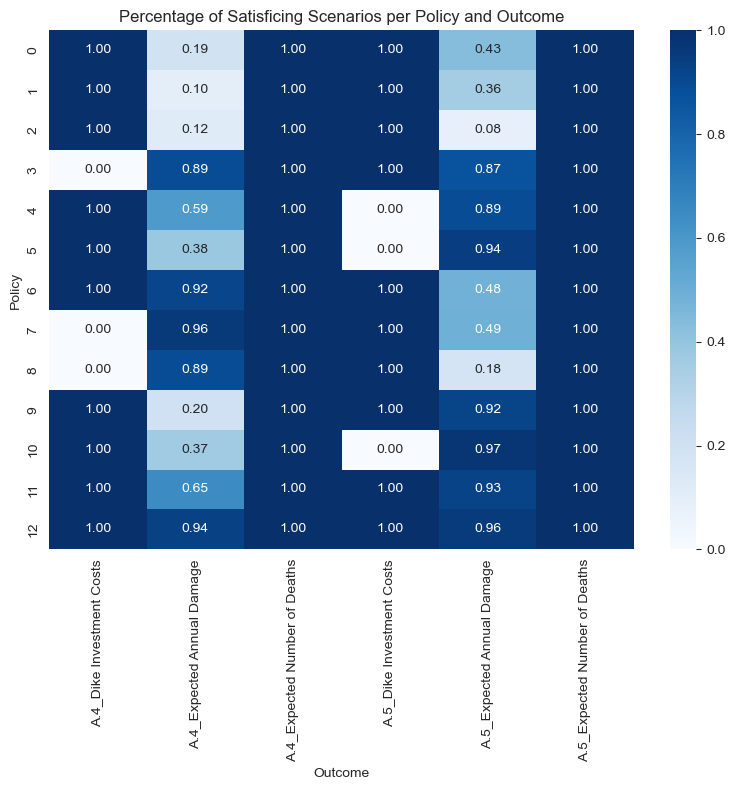

In [192]:
plt.figure(figsize=(8, 8))
sns.heatmap(satisficing_df, annot=True, cmap='Blues', fmt=".2f")
plt.title("Percentage of Satisficing Scenarios per Policy and Outcome")
plt.xlabel("Outcome")
plt.ylabel("Policy")
plt.tight_layout()
plt.show()